07.02.23

# Analyse slices annotated by experts

- Open, organise and analyse the slices that have been annotated by the experts.
- Compute some metrics to get inter-observer variability-
- Visualize marginal entropy on selected slices.

Author: Prisca Dotti  
Last modified: 22.04.2024

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys
sys.path.append("..")

In [121]:
import numpy as np
import os
import imageio.v2 as imageio
import warnings
import math
import seaborn as sns
import pandas as pd
import scipy
import scikit_posthocs as sp
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
from scipy.stats import kruskal
from sklearn.metrics import cohen_kappa_score, jaccard_score
from matplotlib.colors import ListedColormap
from itertools import combinations

# import glob
# from skimage.io import imsave

from data.data_processing_tools import (
    process_raw_predictions,
    preds_dict_to_mask,
    one_sided_non_inferiority_ttest,
)
from utils.in_out_tools import load_movies_ids

# set up matplotlib parameters so that .svg can correctly be processed in illustrator
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["font.family"] = ["sans-serif"]
matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["savefig.dpi"] = 600
sns.set_style("ticks")

# Set up the matplotlib figures
PROPS = {
    "boxprops": {"facecolor": "none", "edgecolor": "black"},
    "medianprops": {"color": "black"},
    "whiskerprops": {"color": "black"},
    "capprops": {"color": "black"},
}

In [3]:
slices_ids = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
slice_to_movie_id = {
    "01": "15",
    "02": "20",
    "03": "34",
    "04": "05",
    "05": "10",
    "06": "25",
    "07": "32",
    "08": "34",
    "09": "40",
    "10": "45",
}
slice_to_frame_id = {
    "01": 54 - 1,
    "02": 445 - 1,
    "03": 430 - 1,
    "04": 351 - 1,
    "05": 410 - 1,
    "06": 109 - 1,
    "07": 950 - 1,
    "08": 894 - 1,
    "09": 898 - 1,
    "10": 667 - 1,
}

#### Load slices annotated by experts

In [4]:
expert_ids = ["RJ", "ME", "EN", "NS", "MW", "CS"]

# make expert ids anonymous
anon_ids = {expert_id: "expert_" + str(i) for i, expert_id in enumerate(expert_ids)}
anon_ids_list = list(anon_ids.values())

# Load all .tif files and save them in a dictionary
annotations_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices"
# Dictionary are indexed by the slice id and the expert id
all_segmentations = {}  # dict.fromkeys(anon_ids_list + ["ground_truth", "unet_preds"])
for expert_id in expert_ids:
    all_segmentations[anon_ids[expert_id]] = dict.fromkeys(slices_ids)
    for slice_id in slices_ids:
        all_segmentations[anon_ids[expert_id]][slice_id] = imageio.volread(
            os.path.join(annotations_dir, expert_id, "sample" + slice_id + ".tif")
        )

#### Load slices from annotated dataset

In [5]:
dataset_dir = os.path.join("..", "data", "sparks_dataset")

all_segmentations["ground_truth"] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations["ground_truth"][slice_id] = np.asarray(
        imageio.volread(os.path.join(dataset_dir, (movie_id + "_class_label.tif")))
    )[frame_id]

#### Load slices from UNet predictions

In [6]:
# Parameters
movie_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
event_types = ["sparks", "puffs", "waves"]
training_name = "final_model"
epoch = 100000
inference_mode = "overlap"

In [7]:
# Load predictions
preds_dir = os.path.join(
    "..", "evaluation", "inference_script", training_name, f"inference_{inference_mode}"
)

preds_segmentation = {}
for movie_id in movie_ids:
    preds_dict = {}

    for event_type in event_types:
        filename = os.path.join(
            preds_dir,
            f"{training_name}_{epoch}_{movie_id}_{inference_mode}_segmented_{event_type}.tif",
        )
        preds_dict[event_type] = np.asarray(imageio.volread(filename))

    preds_segmentation[movie_id] = preds_dict_to_mask(preds_dict)

In [8]:
all_segmentations["unet_preds"] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations["unet_preds"][slice_id] = preds_segmentation[movie_id][frame_id]

# for slice_id in slices_ids:
#     for annotator in all_segmentations.keys():
#         print(
#             f"Slice {slice_id} - {annotator}: {np.unique(all_segmentations[annotator][slice_id])}"
#         )

### Compute pairwise agreement

In [9]:
all_segmentations.keys()

dict_keys(['expert_0', 'expert_1', 'expert_2', 'expert_3', 'expert_4', 'expert_5', 'ground_truth', 'unet_preds'])

In [32]:
warnings.filterwarnings("ignore")
# for each slice ID, compute inter-annotator agreement and store results in a dataframe
kappa_list = []
for slice_id in slices_ids:
    # get mask of pixels ignored during training
    ignore_mask = (all_segmentations["ground_truth"][slice_id] == 4).flatten()

    for rater_1, rater_2 in combinations(all_segmentations.keys(), 2):
        mask_1 = all_segmentations[rater_1][slice_id].flatten()
        mask_2 = all_segmentations[rater_2][slice_id].flatten()

        # print(f"A1: {rater_1} - A2: {rater_2} - Slice: {slice_id}")

        kappa = cohen_kappa_score(
            mask_1,
            mask_2,
            labels=[0, 1, 2, 3],
        )

        # remove pixels ignored during training
        mask_1 = mask_1[~ignore_mask]
        mask_2 = mask_2[~ignore_mask]

        # compute jaccard similarity for each class
        jaccard_scores = jaccard_score(
            mask_1,
            mask_2,
            labels=[0, 1, 2, 3],
            average=None,
        )

        # If a label is not present in both masks, set the Jaccard score for that label to np.nan
        for i in range(1, 4):
            if i not in mask_1 and i not in mask_2:
                jaccard_scores[i] = np.nan

        jaccard_0, jaccard_1, jaccard_2, jaccard_3 = jaccard_scores
        jaccard_average = np.nanmean(
            [jaccard_1, jaccard_2, jaccard_3]
        )  # Use np.nanmean to ignore NaN values

        kappa_list.append(
            {
                "slice_id": slice_id,
                "annotator_1": rater_1,
                "annotator_2": rater_2,
                "kappa": kappa,
                "jaccard_sparks": jaccard_1,
                "jaccard_waves": jaccard_2,
                "jaccard_puffs": jaccard_3,
                "jaccard_average": jaccard_average,
            }
        )

        kappa_list.append(
            {
                "slice_id": slice_id,
                "annotator_1": rater_2,
                "annotator_2": rater_1,
                "kappa": kappa,
                "jaccard_sparks": jaccard_1,
                "jaccard_waves": jaccard_2,
                "jaccard_puffs": jaccard_3,
                "jaccard_average": jaccard_average,
            }
        )

kappa_df = pd.DataFrame(kappa_list)

warnings.filterwarnings("default")
display(kappa_df)

,slice_id,annotator_1,annotator_2,kappa,jaccard_sparks,jaccard_waves,jaccard_puffs,jaccard_average
0,01,expert_0,expert_1,0.796058,NaN,NaN,0.673123,0.673123
1,01,expert_1,expert_0,0.796058,NaN,NaN,0.673123,0.673123
2,01,expert_0,expert_2,0.253748,NaN,NaN,0.150422,0.150422
3,01,expert_2,expert_0,0.253748,NaN,NaN,0.150422,0.150422
4,01,expert_0,expert_3,0.116472,0.0,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...
555,10,ground_truth,expert_5,0.635400,NaN,0.611625,NaN,0.611625
556,10,expert_5,unet_preds,0.810145,NaN,0.810030,NaN,0.810030
557,10,unet_preds,expert_5,0.810145,NaN,0.810030,NaN,0.810030
558,10,ground_truth,unet_preds,0.631392,NaN,0.608990,NaN,0.608990


In [33]:
def filter_df(df, value):
    return df[(df.annotator_1 != value) & (df.annotator_2 != value)]


kappa_df_no_gt = filter_df(kappa_df, "ground_truth")
kappa_df_no_preds = filter_df(kappa_df, "unet_preds")

#### Old plots

In [12]:
# # visualize kappa values
# plt.figure(figsize=(15, 8))
# sns.set_style("ticks")

# ax = sns.boxplot(
#     x="annotator_1", y="kappa", data=kappa_df, color="1.0", linewidth=1, **PROPS
# )

# ax = sns.swarmplot(
#     x="annotator_1", y="kappa", data=kappa_df, hue="annotator_2", palette="husl"
# )  # , size=3)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plt.title("Expert  vs. all experts and all slices", fontsize=20)

# sns.despine()
# plt.show()

In [13]:
# # VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# # visualize jaccard_average values
# plt.figure(figsize=(15,8))
# sns.set_theme(style="whitegrid")

# ax = sns.boxplot(x="annotator_1", y="jaccard_average", data=kappa_df, palette="Set3")
# ax = sns.swarmplot(x="annotator_1", y="jaccard_average", data=kappa_df, color=".5", size=3)

# plt.title("Expert  vs. all experts and all slices")

# plt.show()

In [14]:
# # plot histogram of kappa values --> per vedere se i kappa seguono una distribuzione normale
# plt.figure(figsize=(8, 5))
# # sns.set_theme(style="whitegrid")
# sns.set_style("ticks")

# ax = sns.histplot(
#     kappa_df_no_gt,
#     x="kappa",
#     hue="annotator_1",
#     multiple="stack",
#     palette="husl",
#     shrink=0.8,
#     kde=True,
# )

# plt.title("Expert  vs. all experts and all slices", fontsize=18)

# plt.show()

In [15]:
# # visualize kappa values for each slice
# plt.figure(figsize=(8, 5))
# # sns.set_theme(style="whitegrid")
# sns.set_style("ticks")

# ax = sns.boxplot(
#     x="slice_id", y="kappa", hue="annotator_1", data=kappa_df, palette="Set3"
# )

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title("Expert vs. all experts on each slice", fontsize=18)

In [16]:
# # VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# # visualize jaccard_average values for each slice
# plt.figure(figsize=(15,8))
# sns.set_theme(style="whitegrid")

# ax = sns.boxplot(x="slice_id", y="jaccard_average", hue="annotator_1", data=kappa_df, palette="Set3")

# plt.title("Expert vs. all experts on each slice")

In [17]:
# # visualize kappa values for each annotator
# plt.figure(figsize=(8, 5))
# # sns.set_theme(style="whitegrid")
# sns.set_style("ticks")

# ax = sns.boxplot(
#     x="annotator_1", y="kappa", hue="annotator_2", data=kappa_df, palette="Set3"
# )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plt.title("Pairwise comparison of experts on all slices", fontsize=18)

In [18]:
# VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# visualize jaccard_average values for each annotator
# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(x="annotator_1", y="jaccard_average", hue="annotator_2", data=kappa_df)

#### Visualize confusion matrix

In [106]:
kappa_pivot = kappa_df.pivot_table(
    index="annotator_1", columns="annotator_2", values="kappa", aggfunc="mean"
)
jaccard_sparks_pivot = kappa_df.pivot_table(
    index="annotator_1", columns="annotator_2", values="jaccard_sparks", aggfunc="mean"
)
jaccard_waves_pivot = kappa_df.pivot_table(
    index="annotator_1", columns="annotator_2", values="jaccard_waves", aggfunc="mean"
)
jaccard_puffs_pivot = kappa_df.pivot_table(
    index="annotator_1", columns="annotator_2", values="jaccard_puffs", aggfunc="mean"
)
jaccard_avg_pivot = kappa_df.pivot_table(
    index="annotator_1",
    columns="annotator_2",
    values="jaccard_average",
    aggfunc="mean",
)

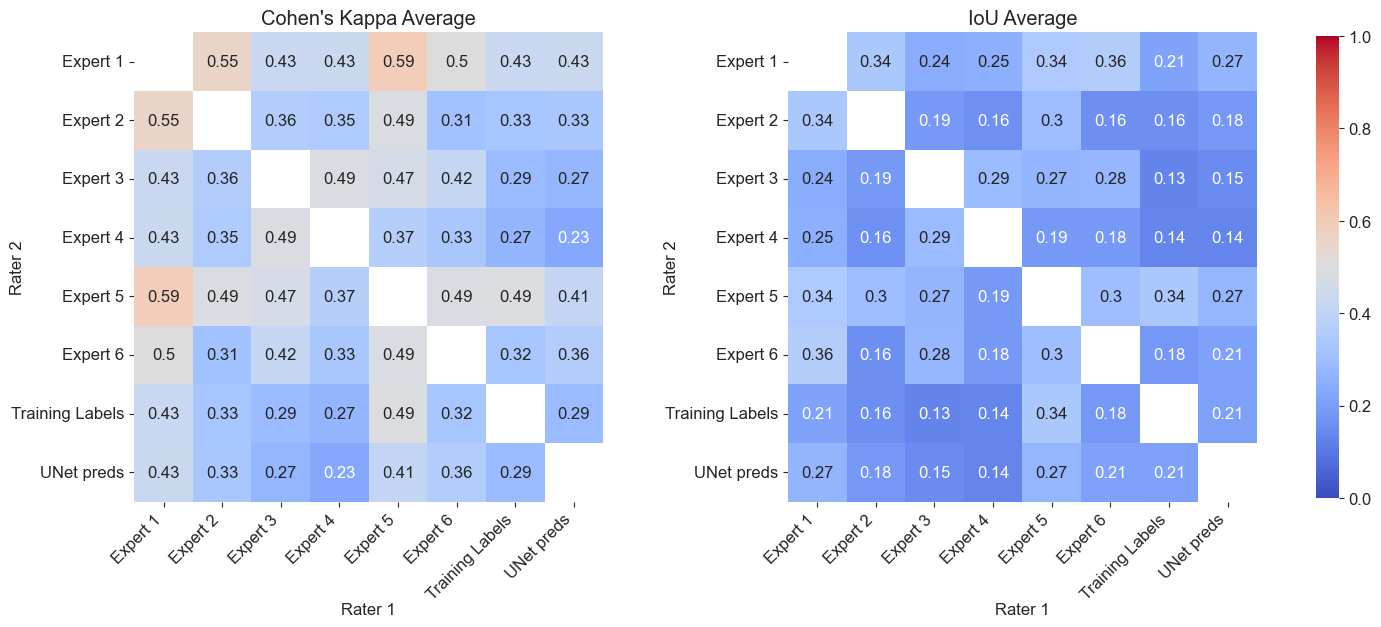

In [107]:
tick_labels = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Training Labels",
    "UNet preds",
]

fig, axs = plt.subplots(
    1, 2, figsize=(16, 8), gridspec_kw={"width_ratios": [1, 1.25], "wspace": 0.35}
)
ax_kappa, ax_jaccard = axs.flatten()

# Adding cbar_kws to customize the colorbar
cbar_kws = {"shrink": 0.75, "fraction": 0.1, "aspect": 20, "pad": 0.1}

sns.heatmap(
    kappa_pivot,
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    ax=ax_kappa,
    cbar=False,  # Do not show the color bar
)
ax_kappa.set_title("Cohen's Kappa Average")  # Set the title for the current subplot
ax_kappa.set_xticklabels(tick_labels, rotation=45, ha="right")
ax_kappa.set_yticklabels(tick_labels, rotation=0, ha="right")
ax_kappa.set_xlabel("Rater 1", labelpad=0)
ax_kappa.set_ylabel("Rater 2", labelpad=-10)


sns.heatmap(
    jaccard_avg_pivot,
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    ax=ax_jaccard,
    cbar_kws=cbar_kws,
)
ax_jaccard.set_title("IoU Average")  # Set the title for the current subplot
ax_jaccard.set_xticklabels(tick_labels, rotation=45, ha="right")
ax_jaccard.set_yticklabels(tick_labels, rotation=0, ha="right")
ax_jaccard.set_xlabel("Rater 1", labelpad=0)
ax_jaccard.set_ylabel("Rater 2", labelpad=-10)

# save figure
save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\THESIS\thesis figures\methods & results"
fig.savefig(
    os.path.join(save_path, "confusion_matrices.png"),
    bbox_inches="tight",
    transparent=True,
    dpi=600,
)

plt.show()

4. Correlation Between Metrics

    Investigate correlations between kappa scores and Jaccard indices to see if they consistently align in their assessment of annotator agreement. This can validate the reliability of segmentation evaluation metrics.

Correlation between kappa and jaccard average: 0.8427373839164017


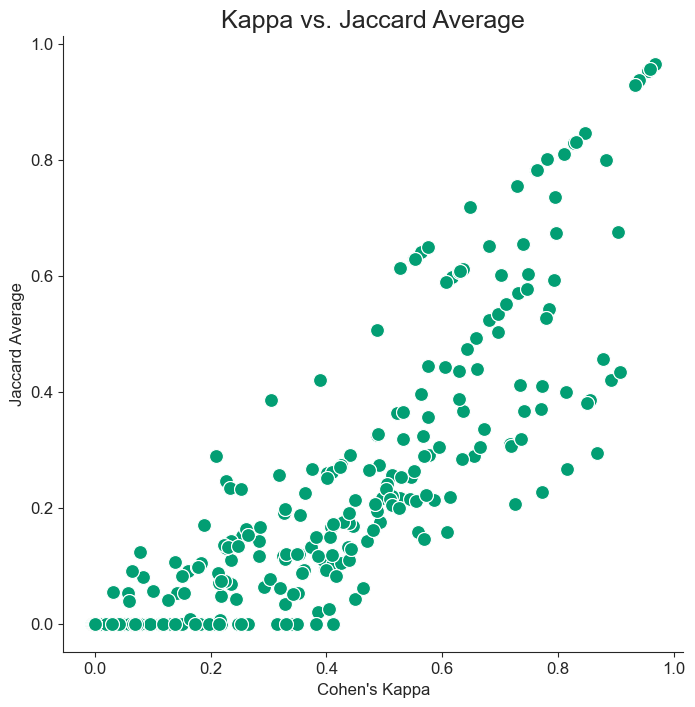

In [109]:
# Compute correlation between kappa and jaccard average
correlation = kappa_df["kappa"].corr(kappa_df["jaccard_average"])
print(f"Correlation between kappa and jaccard average: {correlation}")

# Plot a scatter plot comparing kappa score and average jaccard score in average_df
plt.figure(figsize=(8, 8))
sns.set_style("ticks")

sns.scatterplot(
    x="kappa",
    y="jaccard_average",
    data=kappa_df,
    color=sns.color_palette("colorblind")[2],
    s=100,
)
sns.despine()
plt.title("Kappa vs. Jaccard Average", fontsize=18)
plt.xlabel("Cohen's Kappa")
plt.ylabel("Jaccard Average")

plt.show()

#### Other old plots

In [27]:
# # same as before but without ground truth
# sns.set_style("ticks")

# avg_kappa_df_no_gt = kappa_df_no_gt.pivot_table(
#     index="annotator_1", columns="annotator_2", values="kappa", aggfunc="mean"
# )


# plt.figure(figsize=(20, 10))

# ax = sns.heatmap(
#     avg_kappa_df_no_gt,
#     annot=True,
#     cmap=sns.color_palette("magma_r", as_cmap=True),
#     annot_kws={"size": 24},
#     square=True,
# )
# ax.set_xlabel("Rater 1", fontsize=24)
# ax.set_ylabel("Rater 2", fontsize=24)

# tick_labels = [
#     "Expert 1",
#     "Expert 2",
#     "Expert 3",
#     "Expert 4",
#     "Expert 5",
#     "Expert 6",
#     "UNet preds",
# ]
# ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=22)
# ax.set_yticklabels(tick_labels, rotation=0, ha="right", fontsize=22)

In [111]:
# # compute average kappa values over all slices in a new dataframe without slice column
# slices_avg_df = (
#     kappa_df.groupby(["annotator_1", "annotator_2"])
#     .mean(numeric_only=True)
#     .reset_index()
# )

# plt.figure(figsize=(8, 5))
# # sns.set_theme(style="whitegrid")
# sns.set_style("ticks")

# ax = sns.boxplot(x="annotator_1", y="kappa", data=slices_avg_df, color=".95")
# ax = sns.swarmplot(
#     x="annotator_1",
#     y="kappa",
#     data=slices_avg_df,
#     hue="annotator_2",
#     palette="husl",
#     size=8,
# )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plt.title("Expert  vs. all experts (mean over slices)", fontsize=18)

# plt.show()

## Majority vote

In [112]:
# compute majority vote among all annotators except for unet_preds and ground truth
all_majority_votes = {}
for slice_id in slices_ids:
    all_majority_votes[slice_id] = {}
    for expert in all_segmentations.keys():
        # compute majority vote for all experts and for all experts except for one

        if expert == "unet_preds":
            # compute majority vote for all experts
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds"]:
                    count_votes.append(all_segmentations[other_expert][slice_id])
            all_majority_votes[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

        elif expert not in ["ground_truth", "unet_preds"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds", expert]:
                    count_votes.append(all_segmentations[other_expert][slice_id])
            all_majority_votes[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

# same but including unet_preds in majority vote
all_majority_votes_unet = {}
for slice_id in slices_ids:
    all_majority_votes_unet[slice_id] = {}
    for expert in all_segmentations.keys():
        if expert not in ["ground_truth"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", expert]:
                    count_votes.append(all_segmentations[other_expert][slice_id])

            all_majority_votes_unet[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

In [113]:
# for each slice, for each expert and UNet, compute kappa wrt majority vote

majority_list = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "ground_truth":
            majority_list.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    # 'Majority': 'majority_vote_wrt_'+expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes[slice_id][expert].flatten(),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

# same but including unet_preds in majority vote
majority_list_unet = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "ground_truth":
            majority_list_unet.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    # 'Majority': 'majority_vote_wrt_'+expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes_unet[slice_id][expert].flatten(),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

In [114]:
majority_df = pd.DataFrame(majority_list)
majority_df_unet = pd.DataFrame(majority_list_unet)
print("Majority vote wrt all experts excluding unet_preds:")
display(majority_df.head())
print("Majority vote wrt all experts including unet_preds:")
display(majority_df_unet.head())

Majority vote wrt all experts excluding unet_preds:


,slice_id,Rater,Kappa
0,01,expert_0,0.462349
1,01,expert_1,0.421245
2,01,expert_2,0.472897
3,01,expert_3,0.025125
4,01,expert_4,0.771156


Majority vote wrt all experts including unet_preds:


,slice_id,Rater,Kappa
0,01,expert_0,0.280639
1,01,expert_1,0.253032
2,01,expert_2,0.510358
3,01,expert_3,0.010775
4,01,expert_4,0.502777


In [32]:
# don't use mean and std but median and var because
# I am assuming that the distribution is not normal!

In [34]:
out_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\MANUSCRIPT_cell_calcium\manuscript figures\tables"

majority_df.groupby("Rater").agg({"Kappa": ["median", "var"]}).to_csv(
    os.path.join(out_dir, "kappa_majority_vote.csv")
)
majority_df_unet.groupby("Rater").agg({"Kappa": ["median", "var"]}).to_csv(
    os.path.join(out_dir, "kappa_majority_vote_unet.csv")
)

In [35]:
print("Median and variance of kappa wrt majority vote:")
display(majority_df.groupby("Rater").agg({"Kappa": ["median", "var"]}))

print("Median and variance of kappa wrt majority vote including unet_preds:")
display(majority_df_unet.groupby("Rater").agg({"Kappa": ["median", "var"]}))

Median and variance of kappa wrt majority vote:


Kappa          
              median       var
Rater                         
expert_0    0.534356  0.102638
expert_1    0.418074  0.064504
expert_2    0.423834  0.116614
expert_3    0.358168  0.126407
expert_4    0.440314  0.101014
expert_5    0.554370  0.122026
unet_preds  0.487092  0.059632

Median and variance of kappa wrt majority vote including unet_preds:


Kappa          
              median       var
Rater                         
expert_0    0.566813  0.084024
expert_1    0.323892  0.077279
expert_2    0.453465  0.114314
expert_3    0.404141  0.128825
expert_4    0.490261  0.080744
expert_5    0.630290  0.100014
unet_preds  0.487092  0.059632

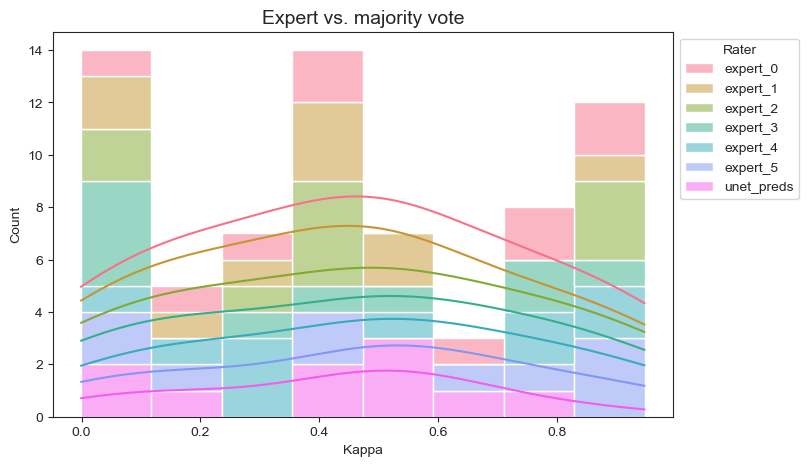

In [36]:
plt.figure(figsize=(8, 5))
sns.set_style("ticks")

ax = sns.histplot(
    data=majority_df, x="Kappa", hue="Rater", multiple="stack", palette="husl", kde=True
)

plt.title("Expert vs. majority vote", fontsize=14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

### Compute kruskal-wallis test

In [37]:
# get dataframe of kappa values for each annotator wrt majority vote
majority_df_pivot = majority_df.pivot(index="Rater", columns="slice_id", values="Kappa")
majority_df_unet_pivot = majority_df_unet.pivot(
    index="Rater", columns="slice_id", values="Kappa"
)

In [38]:
# compute kruskal-wallis test for all annotators
stat, p = kruskal(*majority_df_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat, p))

Statistics=2.549, p=0.863


In [39]:
# compute kruskal-wallis test for all annotators when unet is included in majority vote
stat_unet, p_unet = kruskal(*majority_df_unet_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat_unet, p_unet))

Statistics=3.264, p=0.775


In [40]:
p_adjustment = "holm"  # "holm"  # bonferroni

pvalues = sp.posthoc_dunn(majority_df_pivot.values.tolist(), p_adjust=p_adjustment)
pvalues_unet = sp.posthoc_dunn(
    majority_df_unet_pivot.values.tolist(), p_adjust=p_adjustment
)

print("p values for each annotator wrt majority vote")
print(pvalues)

print("p values for each annotator wrt majority vote (including unet_preds)")
print(pvalues_unet)

p values for each annotator wrt majority vote
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0
p values for each annotator wrt majority vote (including unet_preds)
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0


### Check if UNet is non-inferior to experts' mean

In [41]:
# compute average kappa score for each annotator (without unet_preds) wrt majority vote
majority_df_pivot_t = majority_df.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts and add it to majority dataframe
majority_df_pivot_t["expert_mean"] = majority_df_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_df_pivot_t)


means_per_slice = dict(
    majority_df_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_df.columns.tolist()
majority_df_with_mean = majority_df.copy()
for slice_id, mean in means_per_slice.items():
    mean_df = pd.DataFrame([[slice_id, "expert_mean", mean]], columns=cols)
    majority_df_with_mean = pd.concat(
        [majority_df_with_mean, mean_df], ignore_index=True
    )

# compute average kappa score for each annotator (including unet_preds) wrt majority vote
majority_df_unet_pivot_t = majority_df_unet.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts
majority_df_unet_pivot_t["expert_mean_unet"] = majority_df_unet_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_df_unet_pivot_t)

means_per_slice_unet = dict(
    majority_df_unet_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_df_unet.columns.tolist()
majority_df_unet_with_mean = majority_df_unet.copy()
for slice_id, mean in means_per_slice_unet.items():
    mean_df = pd.DataFrame([[slice_id, "expert_mean_unet", mean]], columns=cols)
    majority_df_unet_with_mean = pd.concat(
        [majority_df_unet_with_mean, mean_df], ignore_index=True
    )

Rater,expert_0,expert_1,expert_2,expert_3,expert_4,expert_5,unet_preds,expert_mean
slice_id,,,,,,,,
01,0.462349,0.421245,0.472897,0.025125,0.771156,0.786107,0.395991,0.489813
02,0.130340,0.114431,0.242428,0.098536,0.221466,0.066489,0.074525,0.145615
03,0.453925,0.264042,0.438408,0.403134,0.305403,0.451409,0.507221,0.386054
04,0.606363,0.493602,0.409260,0.563618,0.549052,0.454473,0.594535,0.512728
05,0.323373,0.414902,0.383684,0.313201,0.331575,-0.000978,0.518594,0.294293
06,0.000000,0.000000,0.000000,-0.000847,0.000000,0.186662,0.466962,0.030969
07,0.719788,0.119897,0.000000,0.000000,0.240877,0.654267,0.589846,0.289138
08,0.745637,0.424568,0.851576,0.790935,0.829211,0.843102,0.190876,0.747505
09,0.940343,0.865788,0.892732,0.914970,0.753366,0.889046,0.068594,0.876041


Rater,expert_0,expert_1,expert_2,expert_3,expert_4,expert_5,unet_preds,expert_mean_unet
slice_id,,,,,,,,
01,0.280639,0.253032,0.510358,0.010775,0.502777,0.660291,0.395991,0.369645
02,0.082804,0.030913,0.208814,0.073614,0.082881,0.210049,0.074525,0.114846
03,0.543788,0.254767,0.426531,0.490433,0.300829,0.606314,0.507221,0.437110
04,0.589838,0.508701,0.480400,0.546969,0.596298,0.476169,0.594535,0.533062
05,0.469402,0.682347,0.386556,0.317850,0.477746,-0.000972,0.518594,0.388822
06,0.214799,0.067452,0.000000,-0.000708,0.154500,0.190922,0.466962,0.104494
07,0.734496,0.119897,0.000000,0.000000,0.240877,0.654267,0.589846,0.291590
08,0.707244,0.393017,0.794605,0.768087,0.770550,0.807093,0.190876,0.706766
09,0.909240,0.867065,0.895507,0.925654,0.712288,0.871913,0.068594,0.863611


In [42]:
# # plot average kappa score for each annotator (without unet_preds) wrt majority vote
# plt.figure(figsize=(8, 5))
# # sns.set_theme(style="whitegrid")
# sns.set_style("ticks")

# df_subset = majority_df_with_mean[
#     majority_df_with_mean["Rater"].isin(["expert_mean", "unet_preds"])
# ]
# ax = sns.boxplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["unet_preds", "expert_mean"],
#     color=".95",
# )
# ax = sns.swarmplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["unet_preds", "expert_mean"],
#     hue="slice_id",
#     palette="husl",
#     size=8,
# )  # , color=".25", size=3)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# tick_labels = ["UNet preds", "Experts mean"]
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(tick_labels)

# # set y axis limits
# ax.set_ylim(0, 1)

# plt.title(
#     "Cohen's kappa of means of experts vs. majority vote and UNet preds vs. majority vote",
#     fontsize=12,
# )

# plt.show()

# # plot average kappa score for each annotator (including unet_preds) wrt majority vote
# plt.figure(figsize=(8, 5))
# # sns.set_theme(style="whitegrid")
# sns.set_style("ticks")

# df_subset = majority_df_unet_with_mean[
#     majority_df_unet_with_mean["Rater"].isin(["expert_mean_unet", "unet_preds"])
# ]
# ax = sns.boxplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["unet_preds", "expert_mean_unet"],
#     color=".95",
# )
# ax = sns.swarmplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["unet_preds", "expert_mean_unet"],
#     hue="slice_id",
#     palette="husl",
#     size=8,
# )  # , color=".25", size=3)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# tick_labels = ["UNet preds", "Experts mean"]
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(tick_labels)

# # set y axis limits
# ax.set_ylim(0, 1)

# plt.title(
#     "Cohen's kappa of means of experts vs. majority vote and UNet preds vs. majority vote",
#     fontsize=12,
# )

# plt.show()

In [43]:
# concatenate dataframes containing unet_preds, expert_mean and expert_mean_unet
only_mean_df = pd.concat(
    [
        majority_df_with_mean[
            majority_df_with_mean["Rater"].isin(["expert_mean", "unet_preds"])
        ],
        majority_df_unet_with_mean[
            majority_df_unet_with_mean["Rater"].isin(["expert_mean_unet"])
        ],
    ],
    ignore_index=True,
)

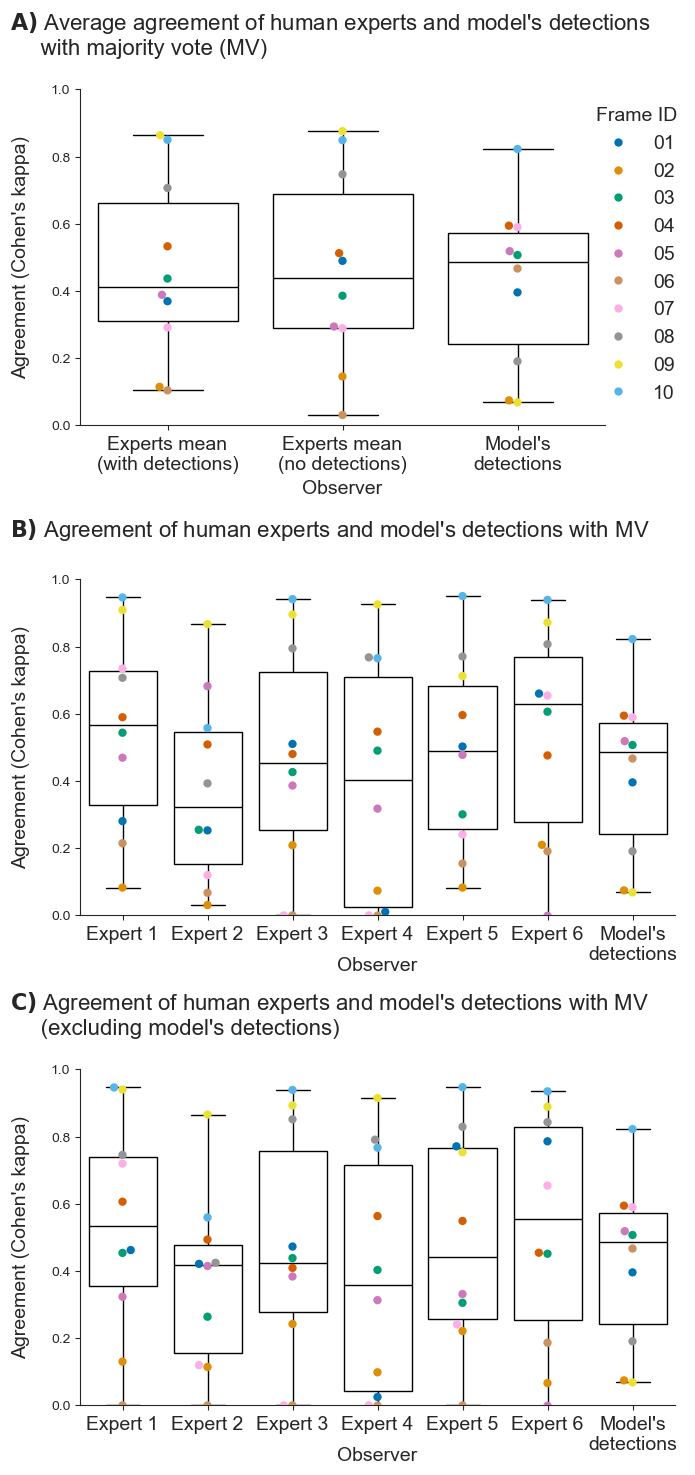

In [45]:
# set figure parameters
# matplotlib.rcParams.update({"font.size": 22})
title_fontsize = 16
fig_fontsize = 14
markersize = 6
swarmplot_palette = "colorblind"

# set directory where plots will be saved
out_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\MANUSCRIPT_cell_calcium\manuscript figures"

fig = plt.figure(constrained_layout=True, figsize=(7, 14))
sns.set_style("ticks")

# create 3 subfigs (width padding=100*hspace[%])
sf1, sf2, sf3 = fig.subfigures(3, 1, hspace=0.15)

# add axes to each subfig (left=0%, bottom=0%, width=100%, height=90%)
ax1 = sf1.add_axes([0, 0, 0.75, 0.8])
ax2 = sf2.add_axes([0, 0, 0.85, 0.8])
ax3 = sf3.add_axes([0, 0, 0.85, 0.8])

# set tick labels
tick_labels_fig1 = [
    "Experts mean\n(with detections)",
    "Experts mean\n(no detections)",
    "Model's\ndetections",
]

tick_labels_fig23 = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Model's\ndetections",
]

# plot average kappa score for each annotator (including unet_preds) wrt majority vote
sns.boxplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_unet", "expert_mean", "unet_preds"],
    linewidth=1,
    ax=ax1,
    **PROPS
)
sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_unet", "expert_mean", "unet_preds"],
    hue="slice_id",
    palette=swarmplot_palette,
    size=markersize,
    ax=ax1,
)

leg = ax1.legend(
    loc="upper left",
    bbox_to_anchor=(0.95, 1),
    fontsize=fig_fontsize,
    frameon=False,
)
leg.set_title("Frame ID", prop={"size": fig_fontsize})

ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(tick_labels_fig1, fontsize=fig_fontsize)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Observer", fontsize=fig_fontsize)
ax1.set_ylabel("Agreement (Cohen's kappa)", fontsize=fig_fontsize, labelpad=15)


# plot kappa values for each annotator wrt majority vote including unet_preds
sns.boxplot(x="Rater", y="Kappa", data=majority_df_unet, linewidth=1, ax=ax2, **PROPS)
sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=majority_df_unet,
    hue="slice_id",
    palette=swarmplot_palette,
    ax=ax2,
    size=markersize,
)

ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(tick_labels_fig23, fontsize=fig_fontsize)
ax2.set_ylim(0, 1)
ax2.set_xlabel("Observer", fontsize=fig_fontsize, labelpad=-5)
ax2.set_ylabel("Agreement (Cohen's kappa)", fontsize=fig_fontsize, labelpad=15)
ax2.legend_.remove()

# plot kappa values for each annotator wrt majority vote
sns.boxplot(
    x="Rater", y="Kappa", data=majority_df, linewidth=1, ax=ax3, **PROPS
)  # , palette=pal)
sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=majority_df,
    hue="slice_id",
    palette=swarmplot_palette,
    ax=ax3,
    size=markersize,
)

ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(tick_labels_fig23, fontsize=fig_fontsize)
ax3.set_ylim(0, 1)
ax3.set_xlabel("Observer", fontsize=fig_fontsize, labelpad=-5)
ax3.set_ylabel("Agreement (Cohen's kappa)", fontsize=fig_fontsize, labelpad=15)
ax3.legend_.remove()

sf1.suptitle(
    r"$\bf{A)}$ Average agreement of human experts and model's detections"
    + "\n     with majority vote (MV)",
    fontsize=title_fontsize,
    ha="left",
    x=-0.1,
    # y=1.25,
)

sf2.suptitle(
    r"$\bf{B)}$ Agreement of human experts and model's detections with MV",
    fontsize=title_fontsize,
    ha="left",
    x=-0.1,
    y=0.95,
)

sf3.suptitle(
    r"$\bf{C)}$ Agreement of human experts and model's detections with MV"
    + "\n     (excluding model's detections)",
    fontsize=title_fontsize,
    ha="left",
    va="top",
    x=-0.1,
    # y=1.25,
)

sns.despine()

plt.savefig(
    os.path.join(out_dir, "boxplots_experts_unet_MV.pdf"),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

plt.show()

In [46]:
# compute if unet_preds is non-inferior to expert_mean
tstat, pvalue = one_sided_non_inferiority_ttest(
    sample1=majority_df_pivot_t["expert_mean"],
    sample2=majority_df_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (without unet preds): ", tstat)
print("pvalue (without unet preds): ", pvalue)

tstat_unet, pvalue_unet = one_sided_non_inferiority_ttest(
    sample1=majority_df_unet_pivot_t["expert_mean_unet"],
    sample2=majority_df_unet_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (with unet preds): ", tstat_unet)
print("pvalue (with unet preds): ", pvalue_unet)

tstat (without unet preds):  0.32407963214535407
pvalue (without unet preds):  0.3766412579406661
tstat (with unet preds):  0.3842846233670569
pvalue (with unet preds):  0.354844817633522


### Compute inter-rater agreement of experts only using Fleiss' kappa

In [47]:
experts_ids = [key for key in all_segmentations.keys() if "expert" in key]

# for each slice, gather all flattened annotators' segmentations as data array
flattened_segmentations = {}
for slice_id in slices_ids:
    for expert in experts_ids:
        if slice_id not in flattened_segmentations.keys():
            flattened_segmentations[slice_id] = []
        flattened_segmentations[slice_id].append(
            all_segmentations[expert][slice_id].flatten()
        )

    # transform list in array and transpose
    flattened_segmentations[slice_id] = np.array(flattened_segmentations[slice_id]).T

In [48]:
# aggregate raters
aggregated_segmentations = {}
for slice_id in slices_ids:
    aggregated_segmentations[slice_id] = aggregate_raters(
        flattened_segmentations[slice_id], n_cat=4
    )[0]

In [49]:
# compute fleiss kappa
fleiss_scores = {}
for slice_id in slices_ids:
    fleiss_scores[slice_id] = fleiss_kappa(table=aggregated_segmentations[slice_id])

In [50]:
# store fleiss kappa scores in dataframe
fleiss_df = pd.DataFrame.from_dict(
    fleiss_scores, orient="index", columns=["Fleiss_Kappa"]
)

In [51]:
# Calculate the average of the other rows
average_row = fleiss_df.mean()

# Add the average row to fleiss_df
fleiss_df.loc["average"] = average_row

In [52]:
fleiss_df.to_csv(os.path.join(out_dir, "tables", "fleiss_df.csv"), index=True)

In [53]:
# Compute Fleiss kappa for binary segmentations

# for each slice, gather all flattened annotators' segmentations as data array
flattened_binary_segmentations = {}
for slice_id in slices_ids:
    for expert in experts_ids:
        if slice_id not in flattened_binary_segmentations.keys():
            flattened_binary_segmentations[slice_id] = []
        flattened_binary_segmentations[slice_id].append(
            (all_segmentations[expert][slice_id] != 0).flatten()
        )

    # transform list in array and transpose
    flattened_binary_segmentations[slice_id] = np.array(
        flattened_binary_segmentations[slice_id], dtype=int
    ).T

In [54]:
# aggregate raters
aggregated_binary_segmentations = {}
for slice_id in slices_ids:
    aggregated_binary_segmentations[slice_id] = aggregate_raters(
        flattened_binary_segmentations[slice_id], n_cat=4
    )[0]

In [55]:
# compute fleiss kappa
binary_fleiss_scores = {}
for slice_id in slices_ids:
    binary_fleiss_scores[slice_id] = fleiss_kappa(
        table=aggregated_binary_segmentations[slice_id]
    )

In [56]:
# store fleiss kappa scores in dataframe
binary_fleiss_df = pd.DataFrame.from_dict(
    binary_fleiss_scores, orient="index", columns=["Fleiss_Kappa"]
)

In [57]:
print("Fleiss kappa for segmentations:")
display(fleiss_df)
print("Fleiss kappa for binary segmentations:")
display(binary_fleiss_df)

Fleiss kappa for segmentations:


,Fleiss_Kappa
01,0.400073
02,0.262500
03,0.392914
04,0.498582
05,0.411116
06,0.210344
07,0.140142
08,0.635179
09,0.817437
10,0.775755


Fleiss kappa for binary segmentations:


,Fleiss_Kappa
01,0.423724
02,0.379940
03,0.535884
04,0.626976
05,0.587802
06,0.275065
07,0.140142
08,0.764101
09,0.820575
10,0.775755


## Compute same analysis with ground truth instead of unet preds

In [58]:
# compute majority vote among all annotators except for ground truth
all_majority_votes_gt = {}
for slice_id in slices_ids:
    all_majority_votes_gt[slice_id] = {}
    for expert in all_segmentations.keys():
        # compute majority vote for all experts and for all experts except for one

        if expert == "ground_truth":
            # compute majority vote for all experts
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds"]:
                    count_votes.append(all_segmentations[other_expert][slice_id])
            all_majority_votes_gt[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

        elif expert not in ["ground_truth", "unet_preds"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds", expert]:
                    count_votes.append(all_segmentations[other_expert][slice_id])
            all_majority_votes_gt[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

# same but including unet_preds in majority vote
all_majority_votes_gt_with_gt = {}
for slice_id in slices_ids:
    all_majority_votes_gt_with_gt[slice_id] = {}
    for expert in all_segmentations.keys():
        if expert not in ["unet_preds"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["unet_preds", expert]:
                    count_votes.append(all_segmentations[other_expert][slice_id])

            all_majority_votes_gt_with_gt[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

In [59]:
# for each slice, for each expert and GT, compute kappa wrt majority vote

majority_gt_list = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "unet_preds":
            majority_gt_list.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes_gt[slice_id][expert].flatten(),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

# same but including GT in majority vote
majority_list_gt_with_gt = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "unet_preds":
            majority_list_gt_with_gt.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes_gt_with_gt[slice_id][expert].flatten(),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

In [60]:
majority_gt_df = pd.DataFrame(majority_gt_list)
majority_gt_df_with_gt = pd.DataFrame(majority_list_gt_with_gt)

In [61]:
# majority_gt_df.groupby('Rater').agg({'Kappa': ['median', 'var']}).to_csv(os.path.join(out_dir, 'kappa_majority_vote.csv'))
# majority_gt_df_with_gt.groupby('Rater').agg({'Kappa': ['median', 'var']}).to_csv(os.path.join(out_dir, 'kappa_majority_vote_unet.csv'))

In [62]:
majority_gt_df.groupby("Rater").agg({"Kappa": ["median", "var"]})

Kappa          
                median       var
Rater                           
expert_0      0.534356  0.102638
expert_1      0.418074  0.064504
expert_2      0.423834  0.116614
expert_3      0.358168  0.126407
expert_4      0.440314  0.101014
expert_5      0.554370  0.122026
ground_truth  0.339006  0.040025

In [63]:
majority_gt_df_with_gt.groupby("Rater").agg({"Kappa": ["median", "var"]})

Kappa          
                median       var
Rater                           
expert_0      0.573999  0.057232
expert_1      0.396440  0.066632
expert_2      0.420283  0.111815
expert_3      0.390454  0.121766
expert_4      0.577781  0.070048
expert_5      0.592332  0.118473
ground_truth  0.339006  0.040025

### Compute kruskal-wallis test

In [64]:
# get dataframe of kappa values for each annotator wrt majority vote
majority_gt_df_pivot = majority_gt_df.pivot(
    index="Rater", columns="slice_id", values="Kappa"
)
majorit_gt_df_with_gt_pivot = majority_gt_df_with_gt.pivot(
    index="Rater", columns="slice_id", values="Kappa"
)

In [65]:
# compute kruskal-wallis test for all annotators
stat, p = kruskal(*majority_gt_df_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat, p))

Statistics=3.217, p=0.781


In [66]:
# compute kruskal-wallis test for all annotators when unet is included in majority vote
stat_unet, p_unet = kruskal(*majorit_gt_df_with_gt_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat_unet, p_unet))

Statistics=6.100, p=0.412


In [67]:
p_adjustment = "holm"  # "holm"  # bonferroni

pvalues = sp.posthoc_dunn(majority_gt_df_pivot.values.tolist(), p_adjust=p_adjustment)
pvalues_unet = sp.posthoc_dunn(
    majorit_gt_df_with_gt_pivot.values.tolist(), p_adjust=p_adjustment
)

print("p values for each annotator wrt majority vote")
print(pvalues)

print("p values for each annotator wrt majority vote (including unet_preds)")
print(pvalues_unet)

p values for each annotator wrt majority vote
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0
p values for each annotator wrt majority vote (including unet_preds)
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0


### Check if dataset labelling is non-inferior to experts' mean

In [68]:
# compute average kappa score for each annotator (without GT) wrt majority vote
majority_gt_df_pivot_t = majority_gt_df.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts and add it to majority dataframe
majority_gt_df_pivot_t["expert_mean"] = majority_gt_df_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_gt_df_pivot_t)


means_per_slice = dict(
    majority_gt_df_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_gt_df.columns.tolist()
majority_gt_df_with_mean = majority_gt_df.copy()
for slice_id, mean in means_per_slice.items():
    mean_df = pd.DataFrame([[slice_id, "expert_mean", mean]], columns=cols)
    majority_gt_df_with_mean = pd.concat(
        [majority_gt_df_with_mean, mean_df], ignore_index=True
    )

# compute average kappa score for each annotator (including GT) wrt majority vote
majority_gt_df_with_gt_pivot_t = majority_gt_df_with_gt.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts
majority_gt_df_with_gt_pivot_t["expert_mean_gt"] = majority_gt_df_with_gt_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_gt_df_with_gt_pivot_t)

means_per_slice_gt = dict(
    majority_gt_df_with_gt_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_gt_df_with_gt.columns.tolist()
majority_gt_df_with_gt_with_mean = majority_gt_df_with_gt.copy()
for slice_id, mean in means_per_slice_gt.items():
    mean_df = pd.DataFrame([[slice_id, "expert_mean_gt", mean]], columns=cols)
    majority_gt_df_with_gt_with_mean = pd.concat(
        [majority_gt_df_with_gt_with_mean, mean_df], ignore_index=True
    )

Rater,expert_0,expert_1,expert_2,expert_3,expert_4,expert_5,ground_truth,expert_mean
slice_id,,,,,,,,
01,0.462349,0.421245,0.472897,0.025125,0.771156,0.786107,0.515085,0.489813
02,0.130340,0.114431,0.242428,0.098536,0.221466,0.066489,0.297780,0.145615
03,0.453925,0.264042,0.438408,0.403134,0.305403,0.451409,0.076607,0.386054
04,0.606363,0.493602,0.409260,0.563618,0.549052,0.454473,0.380233,0.512728
05,0.323373,0.414902,0.383684,0.313201,0.331575,-0.000978,0.202523,0.294293
06,0.000000,0.000000,0.000000,-0.000847,0.000000,0.186662,0.225878,0.030969
07,0.719788,0.119897,0.000000,0.000000,0.240877,0.654267,0.187963,0.289138
08,0.745637,0.424568,0.851576,0.790935,0.829211,0.843102,0.605003,0.747505
09,0.940343,0.865788,0.892732,0.914970,0.753366,0.889046,0.582846,0.876041


Rater,expert_0,expert_1,expert_2,expert_3,expert_4,expert_5,ground_truth,expert_mean_gt
slice_id,,,,,,,,
01,0.446114,0.406072,0.492138,0.009419,0.749673,0.784306,0.515085,0.481287
02,0.287084,0.216234,0.278224,0.146718,0.426746,0.127605,0.297780,0.247102
03,0.458105,0.231021,0.388054,0.429018,0.271844,0.530398,0.076607,0.384740
04,0.490873,0.424903,0.449250,0.459666,0.489848,0.451341,0.380233,0.460980
05,0.657126,0.775805,0.391317,0.351890,0.665714,-0.000987,0.202523,0.473477
06,0.320497,0.117419,0.000000,-0.000839,0.223174,0.185160,0.225878,0.140902
07,0.749817,0.119897,0.000000,0.000000,0.240877,0.654267,0.187963,0.294143
08,0.732175,0.386808,0.831528,0.808203,0.818405,0.859425,0.605003,0.739424
09,0.940877,0.865788,0.884059,0.906301,0.753366,0.881608,0.582846,0.872000


In [69]:
# # plot average kappa score for each annotator (without gt) wrt majority vote
# plt.figure(figsize=(8, 5))
# sns.set_theme(style="whitegrid")

# df_subset = majority_gt_df_with_mean[
#     majority_gt_df_with_mean["Rater"].isin(["expert_mean", "ground_truth"])
# ]
# ax = sns.boxplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["ground_truth", "expert_mean"],
#     color=".95",
# )
# ax = sns.swarmplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["ground_truth", "expert_mean"],
#     hue="slice_id",
#     palette="husl",
#     size=8,
# )  # , color=".25", size=3)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# tick_labels = ["Training labels", "Experts mean"]
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(tick_labels)

# # set y axis limits
# ax.set_ylim(0, 1)

# plt.title(
#     "Cohen's kappa of means of experts vs. majority vote and training labels vs. majority vote",
#     fontsize=12,
# )

# plt.show()

# # plot average kappa score for each annotator (including GT) wrt majority vote
# plt.figure(figsize=(8, 5))
# sns.set_theme(style="whitegrid")

# df_subset = majority_gt_df_with_gt_with_mean[
#     majority_gt_df_with_gt_with_mean["Rater"].isin(["expert_mean_gt", "ground_truth"])
# ]
# ax = sns.boxplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["ground_truth", "expert_mean_gt"],
#     color=".95",
# )
# ax = sns.swarmplot(
#     x="Rater",
#     y="Kappa",
#     data=df_subset,
#     order=["ground_truth", "expert_mean_gt"],
#     hue="slice_id",
#     palette="husl",
#     size=8,
# )  # , color=".25", size=3)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# tick_labels = ["Training labels", "Experts mean"]
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(tick_labels)

# # set y axis limits
# ax.set_ylim(0, 1)

# plt.title(
#     "Cohen's kappa of means of experts vs. majority vote and training labels preds vs. majority vote",
#     fontsize=12,
# )

# plt.show()

In [70]:
# concatenate dataframes containing ground_truth, expert_mean and expert_mean_gt
only_mean_df = pd.concat(
    [
        majority_gt_df_with_mean[
            majority_gt_df_with_mean["Rater"].isin(["expert_mean", "ground_truth"])
        ],
        majority_gt_df_with_gt_with_mean[
            majority_gt_df_with_gt_with_mean["Rater"].isin(["expert_mean_gt"])
        ],
    ],
    ignore_index=True,
)

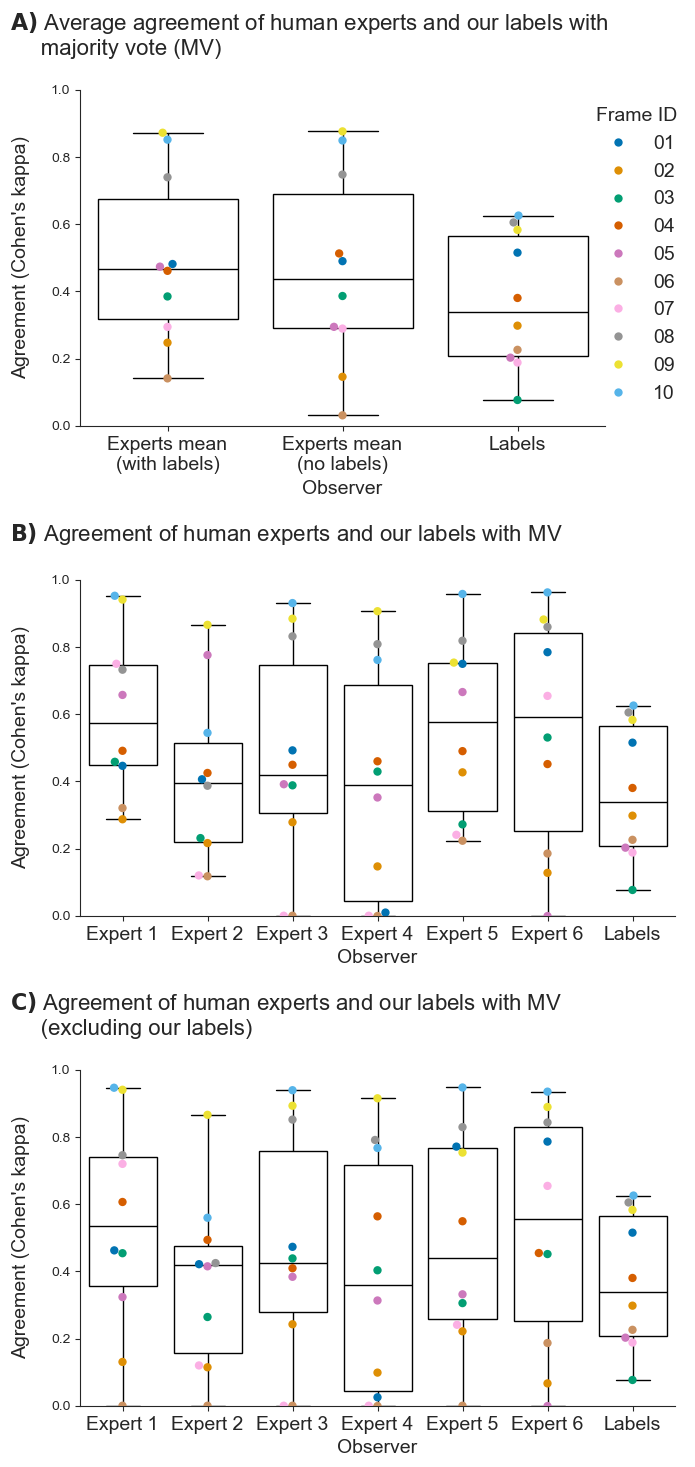

In [72]:
# set figure parameters
# matplotlib.rcParams.update({"font.size": 22})
title_fontsize = 16
fig_fontsize = 14
markersize = 6
swarmplot_palette = "colorblind"

# # create palette where ground_truth is dark grey and all other experts are light grey
# sns.set_color_codes()
# pal = {
#     rater: "darkgray" if rater == "ground_truth" else "lightgray"
#     for rater in only_mean_df.Rater.unique()
# }

# set directory where plots will be saved
out_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\MANUSCRIPT_cell_calcium\manuscript figures"

fig = plt.figure(constrained_layout=True, figsize=(7, 14))
sns.set_style("ticks")

# create 3 subfigs (width padding=100*hspace[%])
sf1, sf2, sf3 = fig.subfigures(3, 1, hspace=0.15)

# add axes to each subfig (left=0%, bottom=0%, width=100%, height=90%)
ax1 = sf1.add_axes([0, 0, 0.75, 0.8])
ax2 = sf2.add_axes([0, 0, 0.85, 0.8])
ax3 = sf3.add_axes([0, 0, 0.85, 0.8])

# set tick labels
tick_labels_fig1 = [
    "Experts mean\n(with labels)",
    "Experts mean\n(no labels)",
    "Labels",
]

tick_labels_fig23 = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Labels",
]

sns.boxplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_gt", "expert_mean", "ground_truth"],
    linewidth=1,
    ax=ax1,
    **PROPS  # ,
    # color='.95', palette=pal
)

sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_gt", "expert_mean", "ground_truth"],
    hue="slice_id",
    palette=swarmplot_palette,
    size=markersize,
    ax=ax1,
)

leg = ax1.legend(
    loc="upper left",
    bbox_to_anchor=(0.95, 1),
    fontsize=fig_fontsize,
    frameon=False,
)
leg.set_title("Frame ID", prop={"size": fig_fontsize})

ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(tick_labels_fig1, fontsize=fig_fontsize)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Observer", fontsize=fig_fontsize)
ax1.set_ylabel("Agreement (Cohen's kappa)", fontsize=fig_fontsize, labelpad=15)


# plot kappa values for each annotator wrt majority vote including labels
sns.boxplot(
    x="Rater", y="Kappa", data=majority_gt_df_with_gt, linewidth=1, ax=ax2, **PROPS
)  # , palette=pal)
sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=majority_gt_df_with_gt,
    hue="slice_id",
    palette=swarmplot_palette,
    ax=ax2,
    size=markersize,
)

ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(tick_labels_fig23, fontsize=fig_fontsize)
ax2.set_ylim(0, 1)
ax2.set_xlabel("Observer", fontsize=fig_fontsize)
ax2.set_ylabel("Agreement (Cohen's kappa)", fontsize=fig_fontsize, labelpad=15)
ax2.legend_.remove()

# plot kappa values for each annotator wrt majority vote excluding labels
sns.boxplot(x="Rater", y="Kappa", data=majority_gt_df, linewidth=1, ax=ax3, **PROPS)
sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=majority_gt_df,
    hue="slice_id",
    palette=swarmplot_palette,
    ax=ax3,
    size=markersize,
)

ax3.set_xticks(ax3.get_xticks())
ax3.set_xticklabels(tick_labels_fig23, fontsize=fig_fontsize)
ax3.set_ylim(0, 1)
ax3.set_xlabel("Observer", fontsize=fig_fontsize)
ax3.set_ylabel("Agreement (Cohen's kappa)", fontsize=fig_fontsize, labelpad=15)
ax3.legend_.remove()

sf1.suptitle(
    r"$\bf{A)}$ Average agreement of human experts and our labels with"
    + "\n     majority vote (MV)",
    fontsize=title_fontsize,
    ha="left",
    x=-0.1,
    # y=1.25,
)

sf2.suptitle(
    r"$\bf{B)}$ Agreement of human experts and our labels with MV",
    fontsize=title_fontsize,
    ha="left",
    x=-0.1,
    y=0.94,
)

sf3.suptitle(
    r"$\bf{C)}$ Agreement of human experts and our labels with MV "
    + "\n     (excluding our labels)",
    fontsize=title_fontsize,
    ha="left",
    va="top",
    x=-0.1,
    # y=1.25,
)

sns.despine()

plt.savefig(
    os.path.join(out_dir, "boxplots_experts_labels_MV.pdf"),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

plt.show()

In [73]:
# compute if unet_preds is non-inferior to expert_mean
tstat, pvalue = one_sided_non_inferiority_ttest(
    sample1=majority_df_pivot_t["expert_mean"],
    sample2=majority_df_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (without unet preds): ", tstat)
print("pvalue (without unet preds): ", pvalue)

tstat_unet, pvalue_unet = one_sided_non_inferiority_ttest(
    sample1=majority_df_unet_pivot_t["expert_mean_unet"],
    sample2=majority_df_unet_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (with unet preds): ", tstat_unet)
print("pvalue (with unet preds): ", pvalue_unet)

tstat (without unet preds):  0.32407963214535407
pvalue (without unet preds):  0.3766412579406661
tstat (with unet preds):  0.3842846233670569
pvalue (with unet preds):  0.354844817633522


## Visualize sample frame and annotations

In [74]:
anon_ids

{'RJ': 'expert_0',
 'ME': 'expert_1',
 'EN': 'expert_2',
 'NS': 'expert_3',
 'MW': 'expert_4',
 'CS': 'expert_5'}

In [75]:
rater_ids = ["ground_truth", "unet_preds"] + list(anon_ids.values())
rater_ids

['ground_truth',
 'unet_preds',
 'expert_0',
 'expert_1',
 'expert_2',
 'expert_3',
 'expert_4',
 'expert_5']

In [76]:
slices_ids

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

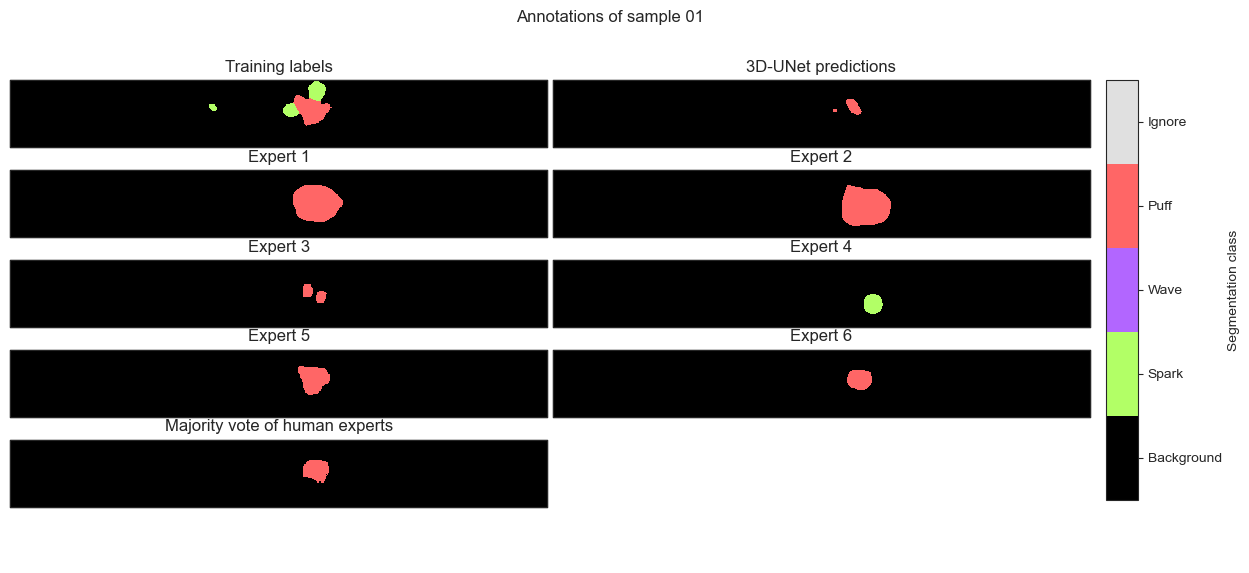

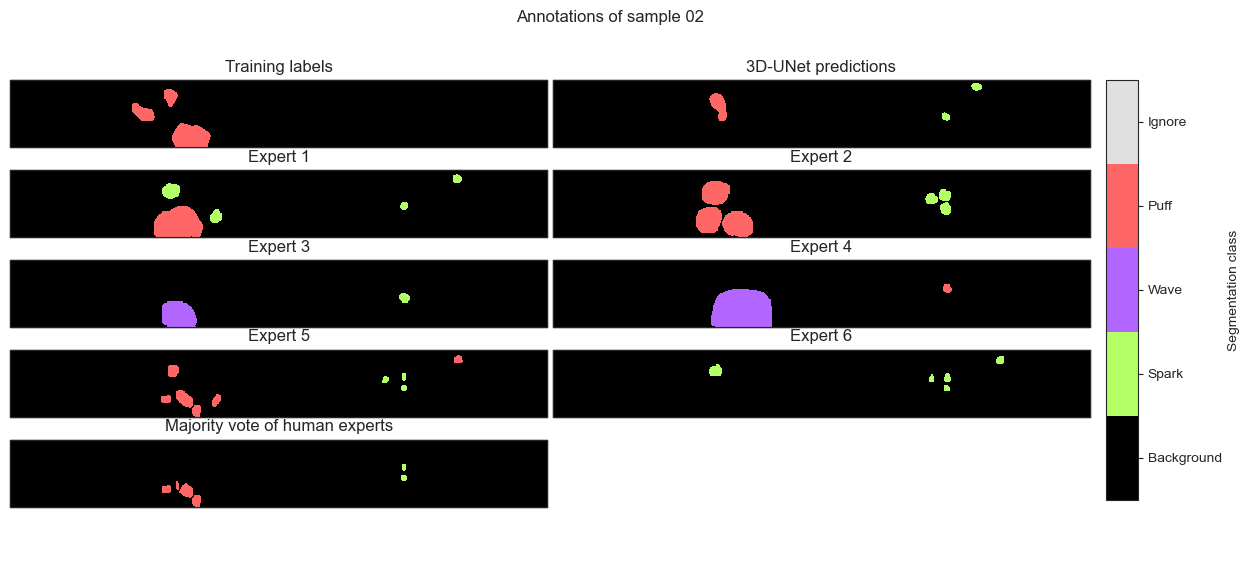

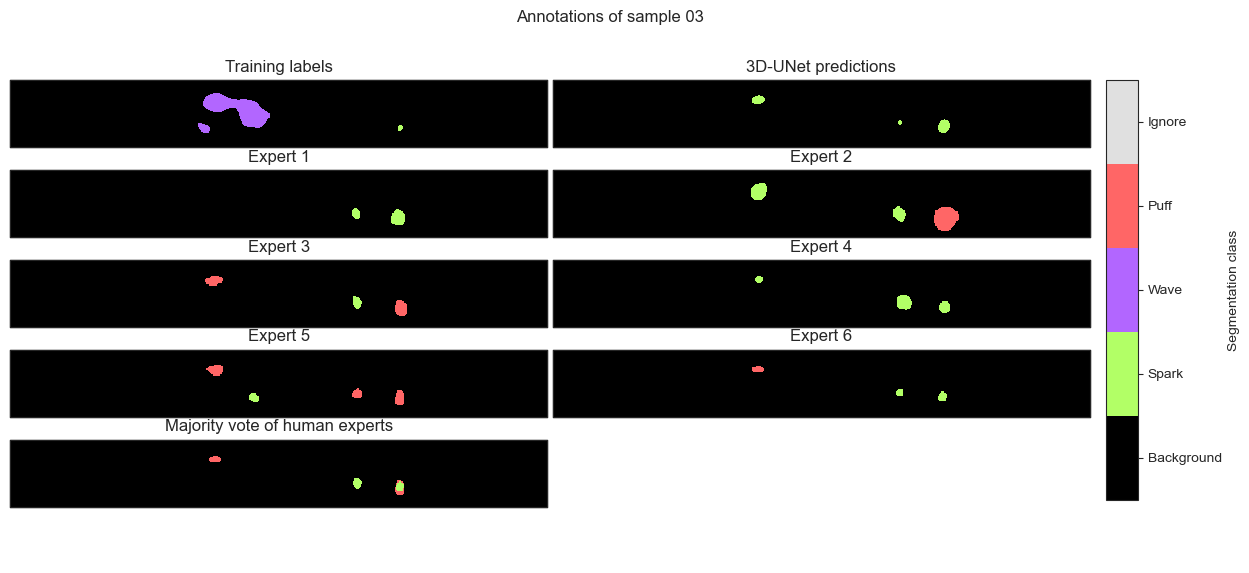

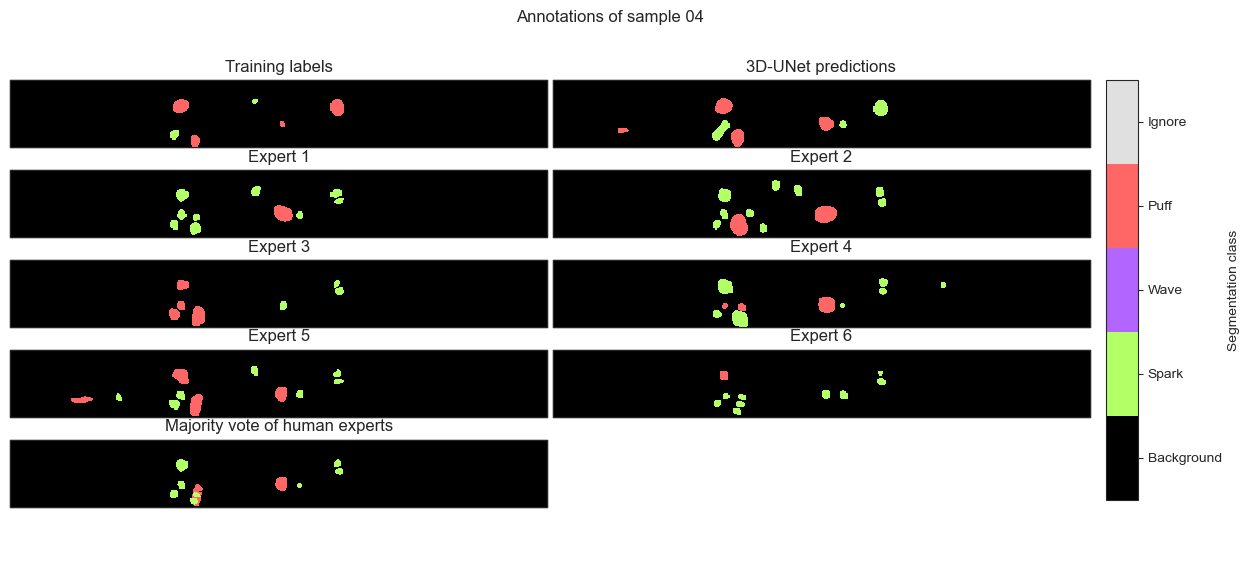

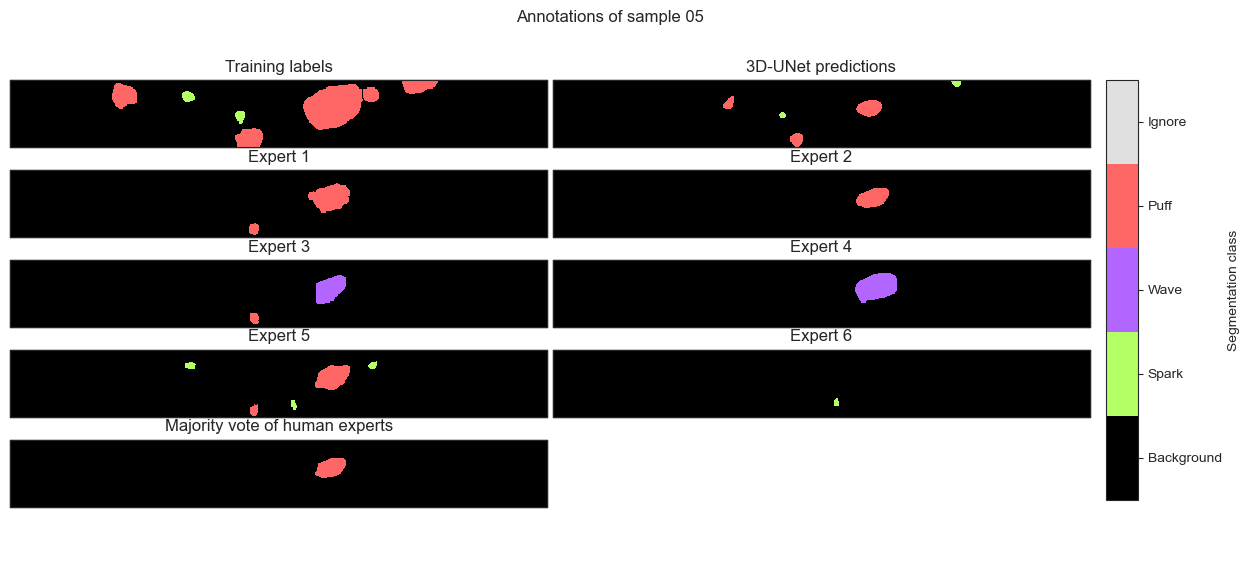

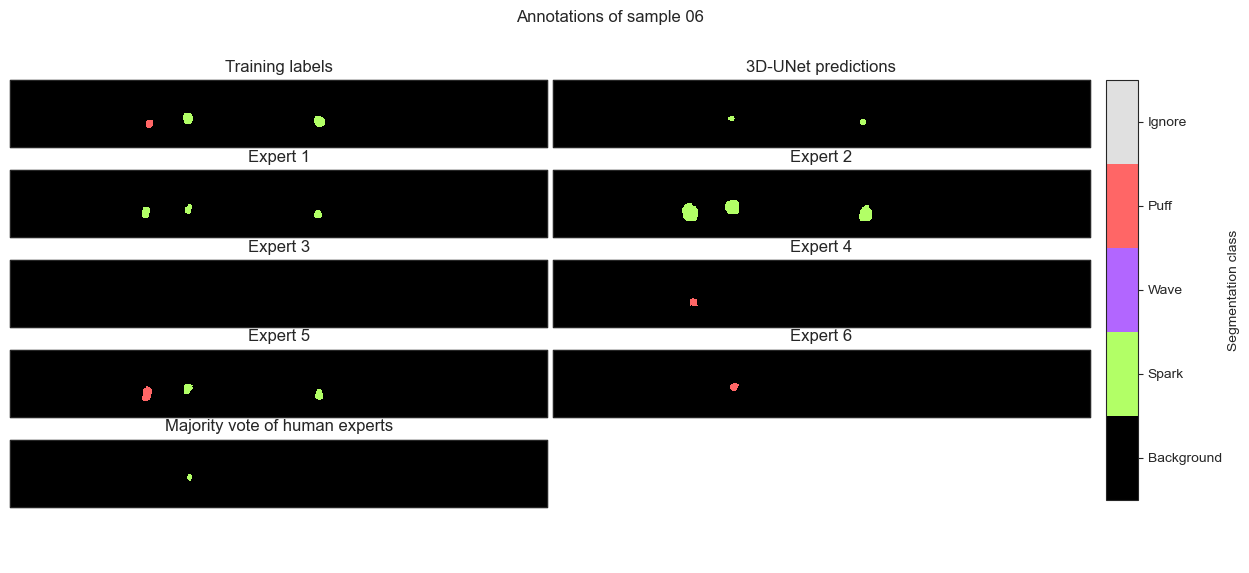

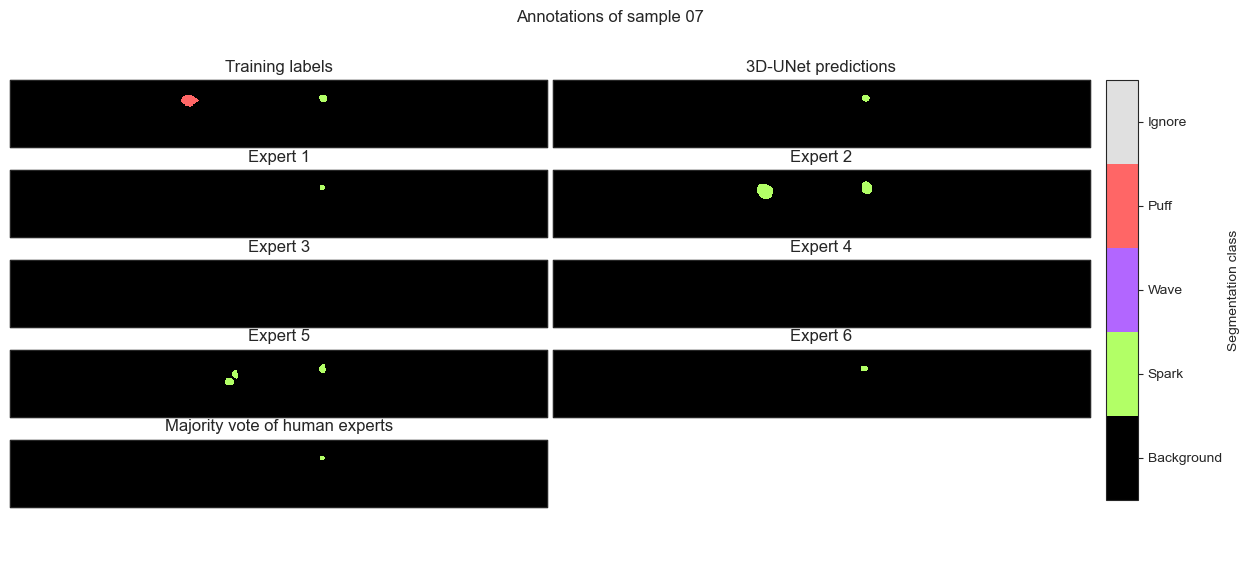

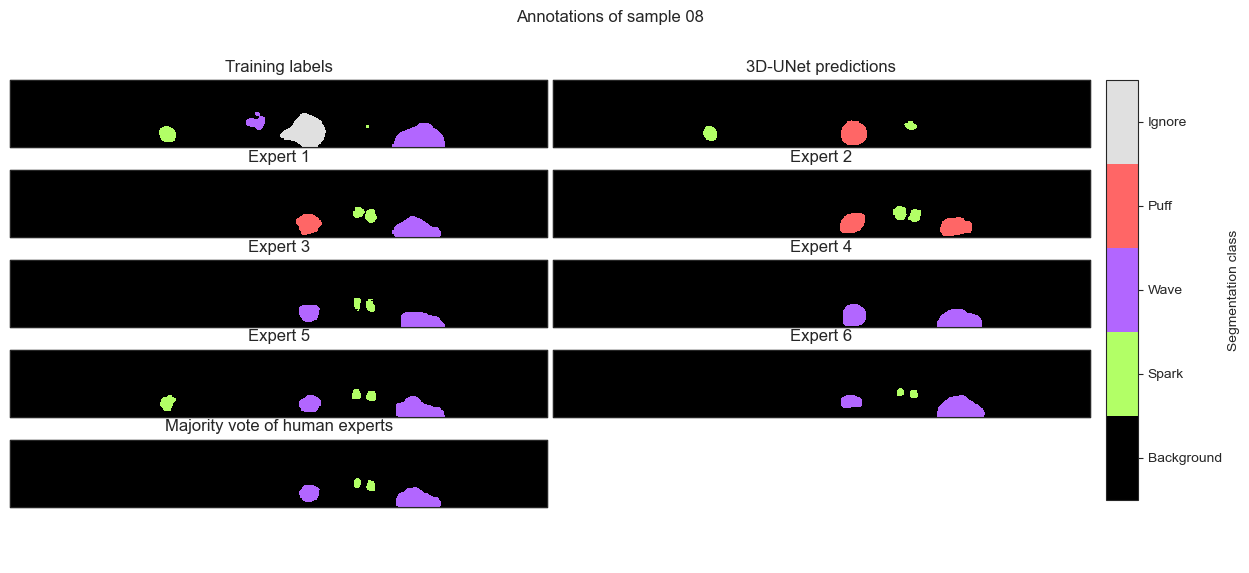

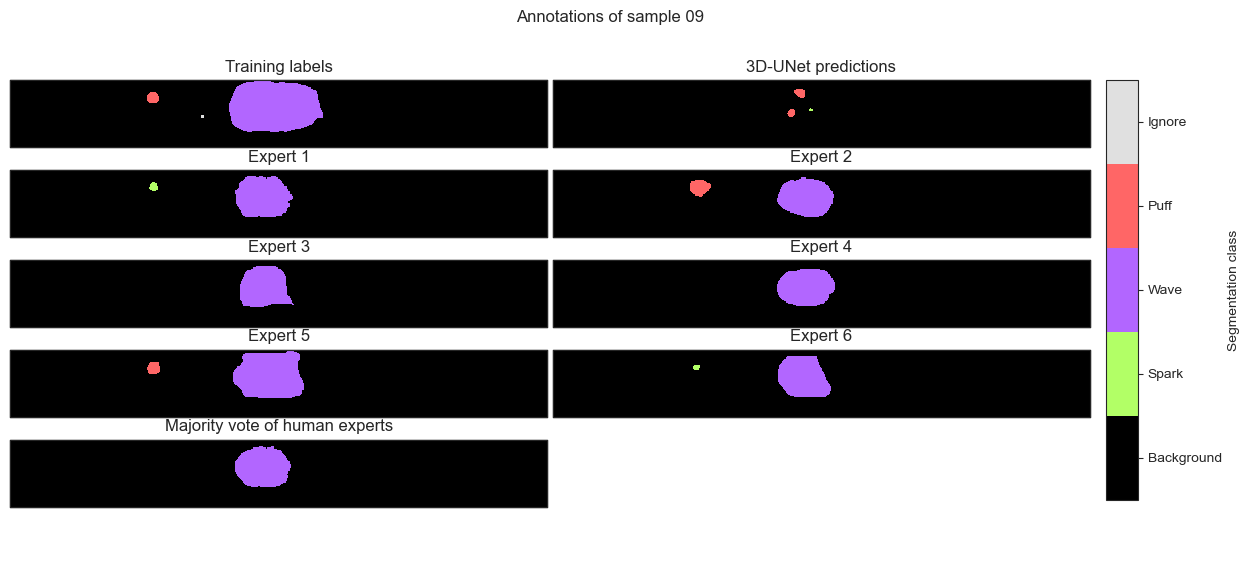

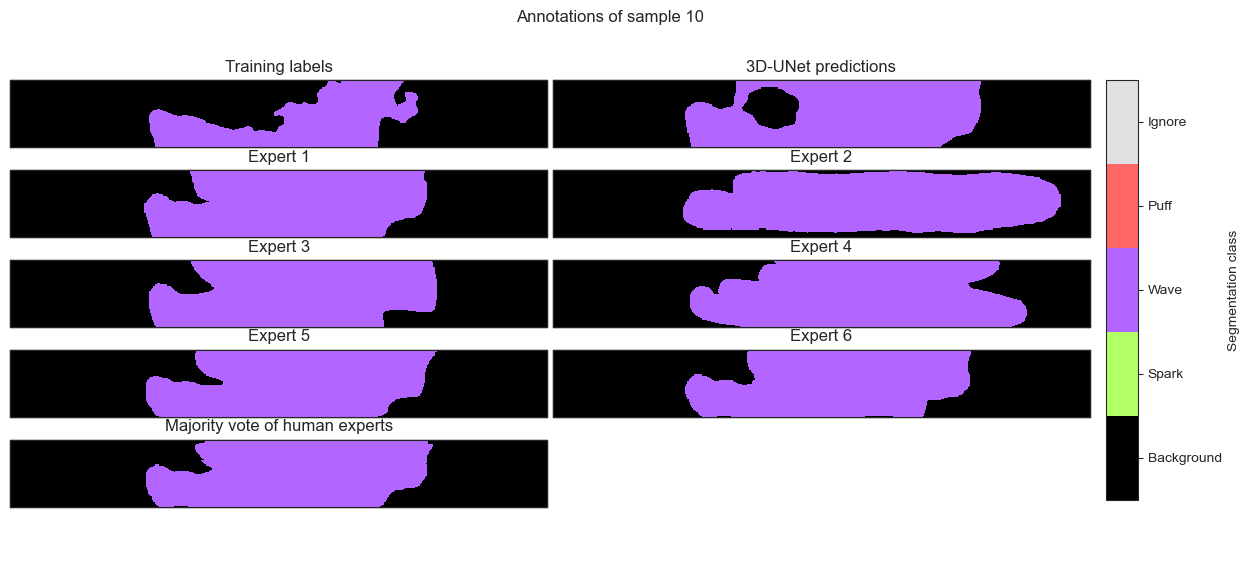

In [77]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# create cmap
green_spark = [178 / 255, 255 / 255, 102 / 255, 1]
red_puff = [255 / 255, 102 / 255, 102 / 255, 1]
purple_wave = [178 / 255, 102 / 255, 255 / 255, 1]
grey_ignore = [224 / 255, 224 / 255, 224 / 255, 1]
black = [0, 0, 0, 1]
colors = [black, green_spark, purple_wave, red_puff, grey_ignore]
cmap = ListedColormap(colors)
ncol = 2
nrow = math.ceil((len(rater_ids) + 1) / 2)

for sample_id in slices_ids:
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 7))
    for i, ax in enumerate(axes.flat):
        if i < len(rater_ids):
            # show segmentation
            if rater_ids[i] == "ground_truth":
                ax.set_title("Training labels")
            elif rater_ids[i] == "unet_preds":
                ax.set_title("3D-UNet predictions")
            else:
                ax.set_title(f"Expert {i-1}")
            data = all_segmentations[rater_ids[i]][sample_id]
            im = ax.imshow(
                data,
                cmap=cmap,
                interpolation="nearest",
                vmin=data_min - 0.5,
                vmax=data_max + 0.5,
            )
            ax.patch.set_edgecolor("black")
            ax.patch.set_linewidth(1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
            # print(f"{rater_ids[i]}: {np.unique(all_segmentations[rater_ids[i]][sample_id])}")

        elif i == len(rater_ids):
            # show majority vote
            ax.set_title("Majority vote of human experts")
            data = all_majority_votes[sample_id]["unet_preds"]
            im = ax.imshow(
                data,
                cmap=cmap,
                interpolation="nearest",
                vmin=data_min - 0.5,
                vmax=data_max + 0.5,
            )
            ax.patch.set_edgecolor("black")
            ax.patch.set_linewidth(1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
        else:
            ax.axis("off")

    # position colorbar on the right side of the plot and tell the colorbar to tick at integers
    cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
    cbar = fig.colorbar(
        im,
        cax=cbar_ax,
        ticks=np.arange(data_min, data_max + 1),
        label="Segmentation class",
    )
    cbar.ax.set_yticklabels(["Background", "Spark", "Wave", "Puff", "Ignore"])
    fig.suptitle(f"Annotations of sample {sample_id}", y=0.9)  # , fontsize=24)
    fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)
    plt.show()

    # save figure
    save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\manuscript figures\inter-rater variability"
    # fig.savefig(
    #     os.path.join(save_path, f"segmentation_sample_{sample_id}.svg"),
    #     bbox_inches="tight",
    #     transparent=True,
    #     dpi=00,
    # )

### Majority vote

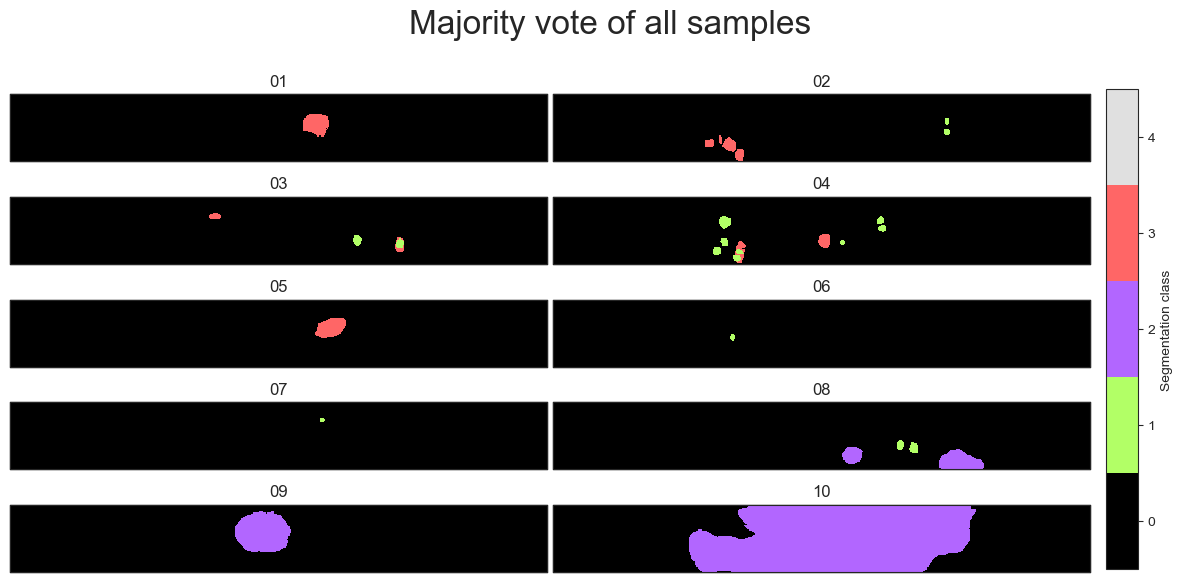

In [78]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# create cmap
green_spark = [178 / 255, 255 / 255, 102 / 255, 1]
red_puff = [255 / 255, 102 / 255, 102 / 255, 1]
purple_wave = [178 / 255, 102 / 255, 255 / 255, 1]
grey_ignore = [224 / 255, 224 / 255, 224 / 255, 1]
black = [0, 0, 0, 1]
colors = [black, green_spark, purple_wave, red_puff, grey_ignore]
cmap = ListedColormap(colors)

ncol = 2


nrow = math.ceil(len(slices_ids) / 2)


fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 8))


for i, ax in enumerate(axes.flat):
    # show majority vote segmentation

    ax.set_title(slices_ids[i])

    data = all_majority_votes[slices_ids[i]]["unet_preds"]

    im = ax.imshow(
        data,
        cmap=cmap,
        interpolation="nearest",
        vmin=data_min - 0.5,
        vmax=data_max + 0.5,
    )

    # add black border to subplot

    ax.patch.set_edgecolor("black")

    ax.patch.set_linewidth(1)

    # remove ticks from subplot

    ax.set_xticks([])

    ax.set_yticks([])

    # remove grid from subplot

    ax.grid(False)


fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)


# position colorbar on the right side of the plot and tell the colorbar to tick at integers


cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(
    im, cax=cbar_ax, ticks=np.arange(data_min, data_max + 1), label="Segmentation class"
)


fig.suptitle(f"Majority vote of all samples", fontsize=24, y=0.9)


plt.show()

### Visualize original frames

In [122]:
# Load original frames
frames_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices"

frames = {}
for sample_id in slices_ids:
    frame_id = slice_to_frame_id[sample_id] + 1
    frames[sample_id] = np.asarray(
        imageio.imread(frames_dir + f"\\sample{sample_id}_slice{frame_id:03}.tif")
    )

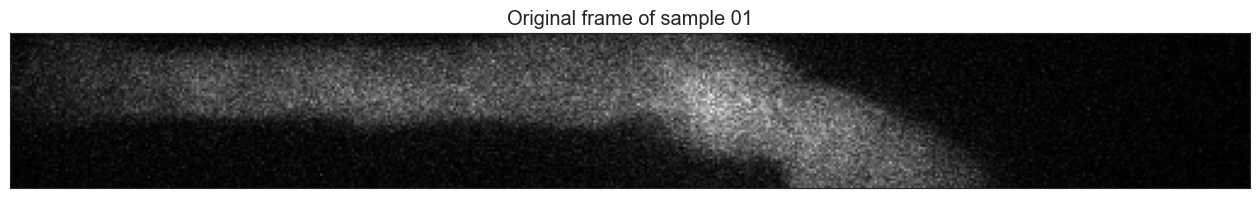

TypeError: join() got an unexpected keyword argument 'bbox_inches'

In [125]:
# plot original frames
for sample_id in slices_ids:
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(frames[sample_id], cmap="gray")
    ax.set_title(f"Original frame of sample {sample_id}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    plt.show()

    # save original frames
    save_path = (
        r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\figures"
    )
    fig.savefig(
        os.path.join(save_path, f"original_frame_sample_{sample_id}.png"),
        bbox_inches="tight",
    )

### Visualize all majority votes of a given frame

In [81]:
frame_id = "07"

expert_0: [0 1]
expert_1: [0 1]
expert_2: [0 1]
expert_3: [0 1]
expert_4: [0 1]
expert_5: [0 1]
unet_preds: [0 1]


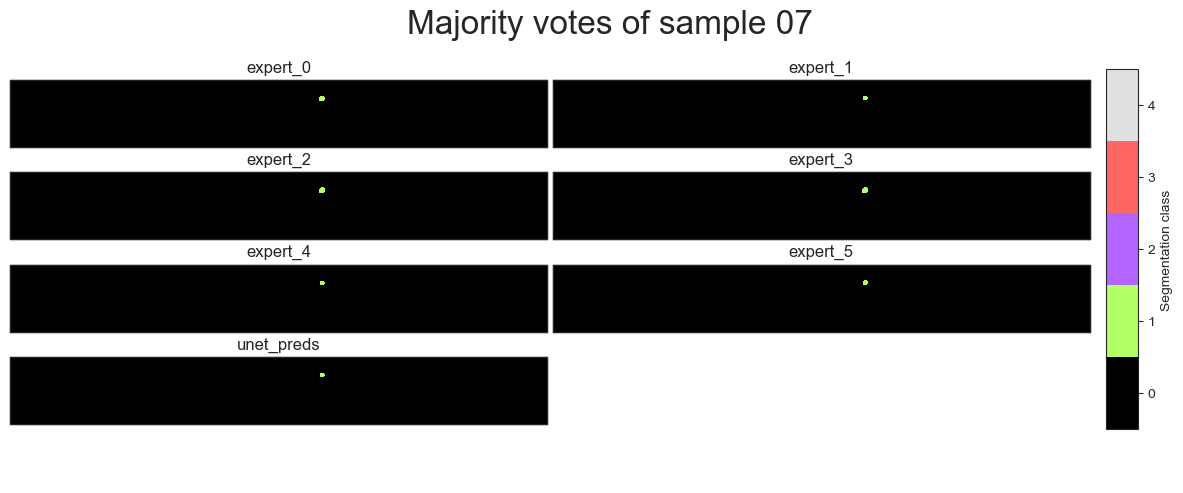

In [82]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# create cmap
green_spark = [178 / 255, 255 / 255, 102 / 255, 1]
red_puff = [255 / 255, 102 / 255, 102 / 255, 1]
purple_wave = [178 / 255, 102 / 255, 255 / 255, 1]
grey_ignore = [224 / 255, 224 / 255, 224 / 255, 1]
black = [0, 0, 0, 1]
colors = [black, green_spark, purple_wave, red_puff, grey_ignore]
cmap = ListedColormap(colors)


# get list of raters for which majority vote is available
majority_rater_ids = list(all_majority_votes[frame_id].keys())
ncol = 2
nrow = math.ceil((len(majority_rater_ids)) / 2)
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 6))

for i, ax in enumerate(axes.flat):
    if i < len(majority_rater_ids):
        # show segmentation
        ax.set_title(majority_rater_ids[i])
        data = all_majority_votes[frame_id][majority_rater_ids[i]]
        im = ax.imshow(
            data,
            cmap=cmap,
            interpolation="nearest",
            vmin=data_min - 0.5,
            vmax=data_max + 0.5,
        )
        ax.patch.set_edgecolor("black")
        ax.patch.set_linewidth(1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        print(f"{majority_rater_ids[i]}: {np.unique(data)}")

    else:
        ax.axis("off")


fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)


# position colorbar on the right side of the plot and tell the colorbar to tick at integers
cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(
    im, cax=cbar_ax, ticks=np.arange(data_min, data_max + 1), label="Segmentation class"
)
fig.suptitle(f"Majority votes of sample {frame_id}", fontsize=24, y=0.9)
plt.show()

# save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\figures"
# fig.savefig(save_path+f"\segmentation_sample_{sample_id}.png", bbox_inches='tight')

In [83]:
np.unique(all_majority_votes[frame_id]["expert_1"])

array([0, 1], dtype=int64)

## Visualize marginal entropy

In [115]:
# Calculate the marginal entropy for each pixel
def entropy(p):
    # Filter out zero probabilities to avoid log(0)
    valid_p = p[p > 0]
    return -np.sum(valid_p * np.log2(valid_p))


# Vectorize the entropy function so it can operate over an array axis
v_entropy = np.vectorize(entropy, signature="(n)->()")


# Calculate the marginal entropy for each pixel
def binary_entropy(p):
    # Handle the case where probability is 0 or 1 directly
    p = np.clip(p, 1e-9, 1 - 1e-9)  # Avoid log(0) issues
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

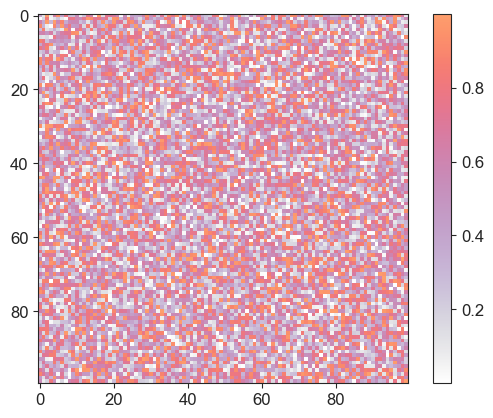

In [117]:
from matplotlib.colors import LinearSegmentedColormap

# Define the RGBA values for stabilo yellow
# Assuming 'stabilo yellow' is RGB (254, 220, 0), you can adjust these values if you have the exact color
color = np.array(
    [[254 / 255, 220 / 255, 0 / 255, alpha] for alpha in np.linspace(0, 1, 256)]
)
stabilo_cmap = LinearSegmentedColormap.from_list("stabilo", color)


# Generate a perceptually uniform colormap with transparency
mpl_cmap = matplotlib.colormaps["magma"]  # Get the original 'viridis' colormap
newcolors = mpl_cmap(np.linspace(0, 0.8, 100))
alphas = np.linspace(0.0, 1.0, 100)  # Start with 0.2 transparency and go up to 0.8
newcolors[:, -1] = alphas
transparent_viridis = LinearSegmentedColormap.from_list("TransparentViridis", newcolors)

# Show some example data with the new colormap
fig, ax = plt.subplots()
example_data = np.random.rand(100, 100)
# heatmap = ax.imshow(example_data, cmap='stabilo_yellow_alpha')
heatmap = ax.imshow(example_data, cmap=transparent_viridis)
plt.colorbar(heatmap)

plt.show()

In [118]:
slices_stacks = {slice_id: [] for slice_id in slices_ids}
for anon_id in anon_ids_list:
    for slice_id in slices_ids:
        slices_stacks[slice_id].append(all_segmentations[anon_id][slice_id])

slices_stacks = {
    slice_id: np.stack(slices_stacks[slice_id], axis=-1) for slice_id in slices_ids
}

In [119]:
for slice_id in slices_ids:
    annotation_stack = slices_stacks[slice_id]
    frame = frames[slice_id]

    # Calculate the frequency of each class label at each pixel
    # Number of classes is 4 (0, 1, 2, 3)
    n_classes = 4
    class_counts = np.zeros(
        (annotation_stack.shape[0], annotation_stack.shape[1], n_classes)
    )

    for class_label in range(n_classes):
        class_counts[:, :, class_label] = np.sum(
            annotation_stack == class_label, axis=-1
        )

    # Normalize counts to probabilities
    class_probabilities = class_counts / len(anon_ids_list)

    # Compute entropy for each pixel
    entropy_map_multi = v_entropy(class_probabilities)

    # Calculate the average entropy across the image
    average_entropy_multi = np.mean(entropy_map_multi)

    # # Convert annotations to binary format (assuming non-zero as positive)
    # binary_annotation_stack = np.where(annotation_stack > 0, 1, 0)

    # # Calculate the probability of feature presence for each pixel
    # p = np.mean(binary_annotation_stack, axis=-1)  # Probability of feature presence

    # # Compute entropy across the entire image
    # entropy_map_binary = binary_entropy(p)

    # # Display the average entropy to understand overall uncertainty
    # average_entropy_binary = np.mean(entropy_map_binary)

    print(f"Average entropy (Multi-class): {average_entropy_multi:.2f}")
    # print(f"Average entropy (Binary): {average_entropy_binary:.2f}")

    # Create figure and axes
    fig, axs = plt.subplots(
        2,
        1,
        figsize=(7, 2),
        gridspec_kw={"height_ratios": [1, 1]},
        constrained_layout=True,
    )
    cmap = transparent_viridis

    entropy_multi_masked = np.ma.masked_where(
        entropy_map_multi < 0.01, entropy_map_multi
    )

    # Multi-class entropy map
    axs[0].imshow(frame, cmap="gray", interpolation="nearest")
    # axs[0].contour(entropy_multi_masked, levels=20, cmap=cmap, linewidths=0.1, vmin=0, vmax=1)
    axs[0].set_title("Original Frame")
    axs[0].axis("off")

    # Binary entropy map
    im1 = axs[1].imshow(
        entropy_multi_masked,
        cmap=cmap,
        interpolation="nearest",
        alpha=0.3,
        vmin=0,
        vmax=1,
    )
    # axs[1].contour(entropy_binary_masked, levels=20, cmap=cmap, linewidths=0.1, vmin=0, vmax=1)
    axs[1].set_title("Multi-Class Marginal Entropy Map")
    axs[1].axis("off")

    # Create a colorbar for the last plot
    cbar = fig.colorbar(
        im1,
        ax=axs.ravel().tolist(),
        orientation="vertical",
        fraction=0.015,
        pad=0.02,
    )
    cbar.set_label("Entropy")

    plt.show()

NameError: name 'frames' is not defined